In [1]:
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.table import Table
from astropy.io import fits
import h5py
from Payne.fitting.genmod import GenMod

import os
import csv

In [99]:
def gensynthspec(specNN='', NNtype='', starpars=([]), plot=False):

    # Read in model spectrum parameters
    # model_filename = os.path.expanduser(model_filename)
    # data, header = fits.getdata(model_filename, header=True)

    # define desired parameters
    if starpars:
        print(f"Spectral parameters:\n[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]\n{starpars}")
    else:
        starpars = ([
                1, # Teff
                1, # log(g)
                1, # [Fe/H]
                1, # [a/Fe]
                1, # vrad
                1, # vstar
                1, # vmic
                1, # lsf (R)
                1, # pc0
                1, # pc1
                1, # pc2
                1, # pc3
        ])
        print(f"Spectral parameters:\n[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]\n{starpars}")
    Teff = starpars[0]
    rv = starpars[4]

    # initialize model generation class
    GM = GenMod()
    GM._initspecnn(
        nnpath=specNN,
        NNtype=NNtype)
    
    # generate the model, output is an array of [wave,flux]
    specmod = GM.genspec(starpars, modpoly=True)

    # add noise
    np.random.seed(0)

    # mu and sigma come from hectochelle data:
    # file: data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5
    # target id: 2076392838230907392
    mu, sigma = 0.055402016862253524, 0.004453214396949145
    noise = np.random.normal(mu, sigma, len(specmod[0]))
    print(np.where(noise < 0))
    flux = specmod[1] + noise

    # plot the synthetic spectrum
    fig, ax = plt.subplots()

    if plot:
        # plot the model
        ax.plot(specmod[0], flux, c='C3')
        ax.plot(specmod[0], specmod[1], c='k')
    
        # wave_min = np.amin(specmod[0])
        # wave_max = np.amax(specmod[0])
        # ax.set_xlim(int(wave_min), int(wave_max))
    
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r"$F_{\lambda}$")
        ax.set_title('Synthetic Spectrum')
    
        plt.show()
        # plt.savefig(f"synth_spec_T{int(Teff)}.png")

    # output spectrum to csv
    with open(f'synth_spec_T{int(Teff)}.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['wave','flux'])

        for row in zip(specmod[0], flux):
            csv_out.writerow(row)
        csv_out.writerows(specmod)
        print(f'synth_spec_RV{int(rv)}.csv saved to {os.getcwd()}')

Spectral parameters:
[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]
[5564.35, 4.16, -0.12, 0.11, 25.865924969318282, 2.74, 1.0, 32007.42, 1.08, 0.06, 0.0, 0.0]
(array([], dtype=int64),)


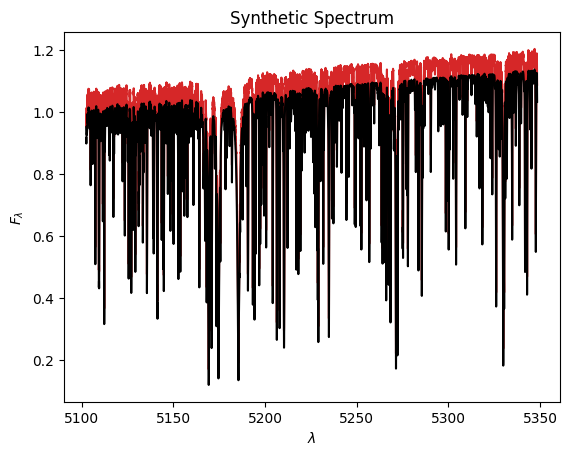

synth_spec_RV25.csv saved to /data/labs/douglste-laf-lab/sofairj/uberMSdemo


In [100]:
specNN='/data/labs/douglaslab/sofairj/demo_binary/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype='LinNet'
starpars = ([
            5564.35, # Teff
            4.16, # log(g)
            -0.12, # [Fe/H]
            0.11, # [a/Fe]
            25.865924969318282, # vrad
            2.74, # vstar
            1.0, # vmic
            32007.42, # lsf (R)
            1.08, # pc0
            0.06, # pc1
            0.0, # pc2
            0.0, # pc3
    ])

gensynthspec(specNN=specNN, NNtype=NNtype, starpars=starpars, plot=True)

In [66]:
def gensynthphot(photNN='', NNtype='', starpars=([]), filtarr='', plot=False):

    if starpars:
        print(f"Photometric parameters:\n[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]\n{starpars}")
    else:
        starpars = ([
                1, # Teff
                1, # log(g)
                1, # [Fe/H]
                1, # [a/Fe]
                1, # log(R)
                1, # Dist
                1, # Av
                3.1 # Rv (3.1)
        ])
        print(f"Photometric parameters:\n[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]\n{starpars}")
    Teff = starpars[0]
    rv = starpars[4]

    # initialize model generation class
    GM = GenMod()
    GM._initphotnn(
        filterarray=filtarr,
        nnpath=photNN
    )

    # generate the model, output is an array of [filt_name,mag]
    photmod = GM.genphot(starpars)

    # grab just mags
    photmod = [photmod[xx] for xx in filtarr]
    

    # photpars_a = ([
    #     sample_i['Teff_a'],sample_i['log(g)_a'],sample_i['[Fe/H]_a'],sample_i['[a/Fe]_a'],
    #     sample_i['log(R)_a'],sample_i['dist'],sample_i['Av'],3.1])
    # photmod_a = genphotfn(photpars_a)
    # photmod_a = [photmod_a[xx] for xx in filtarray]

# 
    from uberMS.utils import photsys

    # all filters the NN is trained on + some information on them
    WAVE_d = photsys.photsys()

    # names of all of the filters the NN is trained on
    photbands_i = WAVE_d.keys()

    # names of the filters used in the "observation" (i.e., filters in filtarr)
    photbands = [x for x in photbands_i if x in filtarr]

    # dict of {filtarr[pb]: wavelength}
    WAVE = {pb:WAVE_d[pb][0] for pb in photbands} 
    
    # plot the synthetic photometry
    fig, ax = plt.subplots()

    if plot:
        # plot the model
        for wavelength, mag in zip(WAVE.values(), photmod):
            print(wavelength)
            print(mag)
            ax.scatter(wavelength, mag, c='k', s=5)
            # ax.plot()
            # ax.plot(photmod[0], photmod[1], c='C3')
            # ax_flux.scatter(w/1E+4,np.log10(mod),marker=s,c='C3',zorder=1,s=5)

    
        # wave_min = np.amin(photmod[0])
        # wave_max = np.amax(photmod[1])
        # ax.set_xlim(int(wave_min), int(wave_max))
    
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r"Mag.")
        ax.set_title('Synthetic Photometry')
    
        plt.show()
        # plt.savefig(f"synth_spec_T{int(Teff)}.png")

    # output spectrum to csv
    with open(f'synth_spec_T{int(Teff)}.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['band','mag','emag'])

        for row in zip(WAVE.keys(), WAVE.values(), photmod):
            csv_out.writerow(row)
            print(row)
        # csv_out.writerows(photmod)

Photometric parameters:
[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]
[5564.35, 4.16, -0.12, 0.11, 3.47, 2.74, 1.0, 3.1]
6217.59
-16.637890924089547
5109.71
-16.175446561166957
7769.02
-16.7349998115222
12350.0
-13.789127976469755
16620.0
-14.885809065278274
21590.0
-14.520227531090923
4775.6
-15.064029344687393
6129.5
-13.96255753187274
7484.6
-15.256110508864127
8657.8
-14.523272733307845


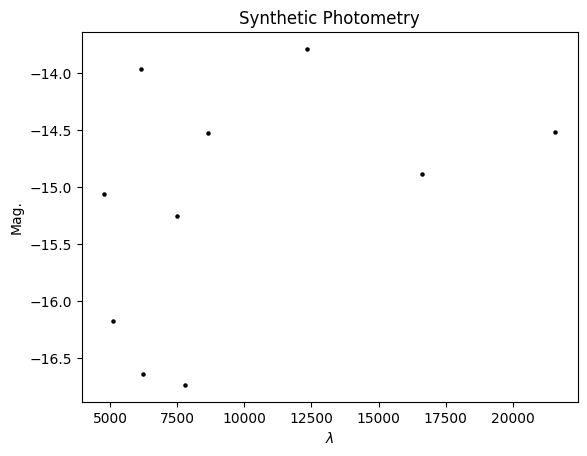

('GaiaDR3_G', 6217.59, -16.637890924089547)
('GaiaDR3_BP', 5109.71, -16.175446561166957)
('GaiaDR3_RP', 7769.02, -16.7349998115222)
('2MASS_J', 12350.0, -13.789127976469755)
('2MASS_H', 16620.0, -14.885809065278274)
('2MASS_Ks', 21590.0, -14.520227531090923)
('PS_g', 4775.6, -15.064029344687393)
('PS_r', 6129.5, -13.96255753187274)
('PS_i', 7484.6, -15.256110508864127)
('PS_z', 8657.8, -14.523272733307845)


In [67]:
photNN='/data/labs/douglaslab/sofairj/demo_binary/models/photNN/'
NNtype='LinNet'
starpars = ([
            5564.35, # Teff
            4.16, # log(g)
            -0.12, # [Fe/H]
            0.11, # [a/Fe]
            3.47, # log(R)
            2.74, # dist
            1.0, # Av
            3.1, # lsf (R)
    ])
filtarr = ['2MASS_H', '2MASS_J', '2MASS_Ks', 'PS_g', 'PS_i', 'PS_r', 'PS_z', 'GaiaDR3_BP', 'GaiaDR3_RP', 'GaiaDR3_G']

gensynthphot(photNN=photNN, NNtype=NNtype, starpars=starpars, filtarr=filtarr, plot=True)

In [65]:
phot = Table.read('/data/labs/douglaslab/sofairj/demo_smes/data/phot.dat',format='ascii')
phot

band,mag,emag
str10,float64,float64
2MASS_H,12.717,0.022
2MASS_J,12.986,0.021
2MASS_Ks,12.636,0.021
GaiaDR3_BP,14.296,0.001
GaiaDR3_G,13.996,0.0002
GaiaDR3_RP,13.531,0.001
PS_g,14.316,0.003
WISE_W1,12.629,0.002
WISE_W2,12.667,0.002


In [112]:
hecto_dir = os.path.expanduser("/data/labs/douglaslab/sofairj/data/hectochelle_rereduction")
hecto_filename = os.path.join(hecto_dir, "data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5")
f = h5py.File(hecto_filename, 'r')


# 2080061393129929088 is the first star listed in the spectrum used here
# 2128158910811247488 is an SB2 whose components are separated in most spectra
# (data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5)
# 2076392838230907392 is another relevant SB2 in NGC 6819
target = str(2076392838230907392)
spec = Table([f[target]['wave'], f[target]['flux'],
              f[target]['eflux']],
              names=('wave', 'flux', 'eflux'))

mu, sigma = np.mean(spec['eflux']), np.std(spec['eflux']) # mean and standard deviation
# np.random.seed(0)
print(mu, sigma)
s = np.random.normal(mu, sigma, 1000)
np.where(s < 0)

0.055402016862253524 0.004453214396949145


(array([], dtype=int64),)